# SETUP ENVIROMENT

In [ ]:
# !pip install av

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 31.4 MB 1.3 MB/s 


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [86]:
### Selecting File Path, Frame Position, Font and Minimum Accuracy
device = "cpu"

# DEFINE FUNCTIONS

In [60]:
### Load Human Segmentation Model
from torchvision.models.detection import MaskRCNN_ResNet50_FPN_V2_Weights, maskrcnn_resnet50_fpn_v2

segment_weights = MaskRCNN_ResNet50_FPN_V2_Weights.COCO_V1
segment_model = maskrcnn_resnet50_fpn_v2(weights=segment_weights)
segment_transforms = segment_weights.transforms()

segment_model.eval().to(device)

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         

In [61]:
### Load Human Keypoint Detection Model

from torchvision.models.detection import keypointrcnn_resnet50_fpn, KeypointRCNN_ResNet50_FPN_Weights

kp_weights = KeypointRCNN_ResNet50_FPN_Weights.COCO_V1
kp_model =  keypointrcnn_resnet50_fpn(weights=kp_weights)
kp_transforms = kp_weights.transforms()

kp_model.eval().to(device)

KeypointRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(640, 672, 704, 736, 768, 800), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.

In [62]:
### Definte VIDEO loading Functions

import os
import av 
import math
import random

from torchvision.io import read_video
from torchvision.transforms.functional import to_pil_image

def load_video(video_path, rotate_angle, frame_position):
    video, audio, meta = read_video(
        video_path,
        pts_unit="sec",
        output_format="TCHW"
    )

    frame_counts = len(video)
    fps = meta['video_fps']
    sample_index = frame_position
    sample_frame = to_pil_image(video[sample_index])
    sample_frame = sample_frame.rotate(rotate_angle, expand=True)
    return video, frame_counts, fps, sample_frame

In [192]:
### Define Segmentation and Mask Conversion Functions

import torch
from torchvision.utils import draw_segmentation_masks
from torchvision.transforms.functional import to_pil_image, pil_to_tensor
import numpy as np

def segment(frame):
    ### Run Predicion Model to find Mask
    input_image = segment_transforms(frame)
    predictions = segment_model([input_image.to(device)])
    masks = predictions[0]['masks']
    scores = predictions[0]['scores']
    boxes = predictions[0]['boxes']
    
    idx = torch.where(scores > min_accuracy)
    main_boxes = torch.unsqueeze(boxes[idx], dim=1)
    index = 0
    max_area = 0
    max_distance = frame.width/3

    for selector, box in enumerate(main_boxes):
        bbox = [
            box[0][0].item(), 
            box[0][1].item(),
            box[0][2].item(),
            box[0][3].item()
        ]
        
        distance, area = dfc(frame, bbox) 
        if distance < max_distance and area > max_area:
            max_area = area
            index = selector
    
    #print("Found "+str(len(masks))+" mask with scores ",str(scores))

    mask = torch.squeeze(masks[index][0], dim=1)
    mask_image = to_pil_image(mask)
    
    ### Find the Minimum Pixel Threshold for Mask
    numpy_mask = mask.detach().numpy()
    counts, values = np.histogram(numpy_mask, bins=10)
    min_counts = np.min(counts)
    idx = np.where(counts == min_counts)
    threshold = values[idx] 
    numpy_bool_mask = numpy_mask > threshold
    bool_mask = torch.tensor(numpy_bool_mask)
    
    return mask, mask_image, bool_mask

In [176]:
### Definte Keypoint detection Functions

import torch

def detect(frame):
    ### Make Predictions on Frame
    body_matrix = kp_transforms(frame)
    predictions = kp_model([body_matrix.to(device)])
    
    ### Extract Boxes, Scores and Keypoints from frame
    boxes = predictions[0]['boxes']
    keypoints = predictions[0]['keypoints']
    scores = predictions[0]['scores']
    
    ### Filter for the main Bounding Box and Keypoints
    idx = torch.where(scores > min_accuracy)
    main_boxes = torch.unsqueeze(boxes[idx], dim=1)
    index = 0
    max_area = 0
    max_distance = frame.width/3

    for selector, box in enumerate(main_boxes):
        bbox = [
            box[0][0].item(), 
            box[0][1].item(),
            box[0][2].item(),
            box[0][3].item()
        ]
        
        distance, area = dfc(frame, bbox) 
        if distance < max_distance and area > max_area:
            max_area = area
            index = selector
            # print("Selected", area, selector, distance)
        # else:
            # print("Not selected", area, selector, distance)
            
    bx = torch.unsqueeze(boxes[idx][index], dim=0)
    kp = torch.unsqueeze(keypoints[idx][index], dim=0)
    SHApoints = getSHAPositions(kp)
    labels = ["ls","rs","lw", "rw", "lh","rh","la","ra"]
    points_image = drawMarkers(labels, SHApoints, frame)
    
    return points_image, SHApoints

In [177]:
### Find Coordinates of the Segmentation Mask Pixels

from PIL import ImageColor

def findSegmentPositions(tensor_image, bool_mask):
    mask = torch.squeeze(bool_mask, 0)
    img_to_draw = tensor_image.detach().clone()
    color = ImageColor.getrgb('blue')
    tensor_color = torch.tensor(color, dtype=torch.uint8)
    img_to_draw[:, mask] = tensor_color[:, None]
    x, y = torch.where(
        (img_to_draw[2] == 255)
        &(img_to_draw[0] == 0)
        &(img_to_draw[1] == 0)
    )
    positions = []
    for x, y in zip(y, x):
        positions.append([x.item(), y.item(), x.item()*y.item()])

    return positions


In [178]:
### Define Visualization FUNCTIONS

from PIL import ImageDraw, ImageFont

marker_font = ImageFont.truetype(font_file, 8)
coco_keypoints = [
    "nose", "left_eye", "right_eye", "left_ear", "right_ear",
    "left_shoulder", "right_shoulder", "left_elbow", "right_elbow",
    "left_wrist", "right_wrist", "left_hip", "right_hip",
    "left_knee", "right_knee", "left_ankle", "right_ankle",
]

def center(bbox):
    center_x = (bbox[2] + bbox[0])/2
    center_y = (bbox[3] + bbox[1])/2
    center = [center_x, center_y]
    return center

def dfc(pic, bbox):
    pic_width = pic.width
    pic_height = pic.height
    
    pic_center = center([0,0, pic_width, pic_height])
    bbox_center = center(bbox)
    
    x_dif = bbox_center[0] - pic_center[0]
    y_dif = bbox_center[1] - pic_center[1]
    bbox_width = bbox[2] - bbox[0]
    bbox_height = bbox[3] - bbox[1] 
    distance = math.sqrt(x_dif * x_dif + y_dif * y_dif)
    area = abs(bbox_width * bbox_height)
    return distance, area

def getSHAPositions(kp):
    ls = kp[0][5]
    rs = kp[0][6]
    
    lw = kp[0][9]
    rw = kp[0][10]

    lh = kp[0][11]
    rh = kp[0][12]

    la = kp[0][15]
    ra = kp[0][16]
    
    points = [
        [ls[0].item(), ls[1].item()],
        [rs[0].item(), rs[1].item()],
        [lw[0].item(), lw[1].item()],
        [rw[0].item(), rw[1].item()],
        [lh[0].item(), lh[1].item()], 
        [rh[0].item(), rh[1].item()], 
        [la[0].item(), la[1].item()], 
        [ra[0].item(), ra[1].item()]
    ]
    
    return points

def drawMarkers(labels, coordinates, image):
    sample = image.copy()
    draw = ImageDraw.Draw(sample) 
            
    for index, point in zip(labels, coordinates):
        label = index 
        radius = 6

        draw.ellipse(
            [(point[0]-radius, point[1]-radius), (point[0]+radius, point[1]+radius)],
            fill="#40389F",
            outline="#ffffff",
            width=1
        )

        draw.text(
            (point[0]-3, point[1]-6),
            str(label),
            fill="#FAFF00",
            font=marker_font,
            align="center"
        )
    return sample

In [179]:
### Define Measurement FUNCTIONS
import math

def twoPointsDistance(pointA, pointB):
    x_dif = (pointA[0] - pointB[0])
    y_dif = (pointA[1] - pointB[1])
    dif = math.sqrt(x_dif * x_dif + y_dif * y_dif)
    return dif


def findMiddle(pointA, pointB):
    middleX = (pointA[0] + pointB[0])/2
    middleY = (pointA[1] + pointB[1])/2
    return middleX, middleY  

def findIntersection(m_type, lp, rp, positions, points):
    ls, rs, lw, rw, lh, rh, la, ra = points
    lThreshold = 0
    rThreshold = 0
    
    if m_type == "HIP":
        lThreshold = twoPointsDistance(findMiddle(ls, rs), ls) * 1.3
        rThreshold = twoPointsDistance(findMiddle(ls, rs), rs) * 1.3
        
    elif m_type == "SHOULDER":
        lThreshold = twoPointsDistance(findMiddle(lh, rh), lh) * 3
        rThreshold = twoPointsDistance(findMiddle(lh, rh), rh) * 3
        
    def findPrecise(lpo, rpo, lThreshold, rThreshold): 
        lsX = lpo[0]
        rsX = rpo[0]
        
        lsY = lpo[1]
        rsY = rpo[1]
       
        center = findMiddle(lpo, rpo)
        left_threshold = center[0] - lThreshold
        right_threshold = center[0] + rThreshold
        
        alpha = (rsY - lsY)/(rsX - lsX)
        beta = (rsX * lsY - rsY * lsX)/(rsX - lsX)
        swing = 1
        #print("Measuring type: ", m_type)
        #print("Linear equation: x*"+str(alpha)+"+"+str(beta))
        #print("Thresholds: ",left_threshold, center[0], right_threshold)
        
        for idx, position in enumerate(positions):
            expectedY = alpha * position[0] + beta
            
            if position[1] >= (expectedY - swing) and  position[1] < (expectedY + swing) and position[0] > left_threshold and position[0] < center[0]:
                lsY = position[1]
                if position[0] < lsX:
                    lsX = position[0]
                    #print("Left", left_threshold,lsX, lsY)
                    
            elif position[1] >= (expectedY - swing) and  position[1] < (expectedY + swing) and  position[0] < right_threshold and position[0] > center[0]:
                rsY = position[1]
                if position[0] > rsX:
                    rsX = position[0]
                    #print("Right",right_threshold,  rsX ,  rsY)

        lsXY = (lsX, lsY)
        rsXY = (rsX, rsY)
        #print("Final", lsXY, rsXY)
        return lsXY, rsXY
    
    if ls[0] < rs[0]:
        #print("\nBACK ", m_type)
        lDot, rDot = findPrecise(lp, rp, lThreshold, rThreshold)
        return lDot, rDot
    else:
        #print("\nFRONT ", m_type)
        lDot, rDot = findPrecise(rp, lp, rThreshold, lThreshold)
        return lDot, rDot

In [180]:
### Definte SHA points approximation FUNCTIONS
def SHAPoints(points, segment_positions):
    ls, rs, lw, rw, lh, rh, la, ra = points
    
    lsXY, rsXY = findIntersection("SHOULDER", ls, rs, segment_positions, points)
    lhXY, rhXY = findIntersection("HIP", lh, rh, segment_positions, points)

    middleHip = findMiddle(lh, rh)
    middleShoulder = findMiddle(ls, rs)
    middleAnkle = findMiddle(la, ra)
    middleBack = findMiddle(middleShoulder, middleHip)

    leftMiddleHip = twoPointsDistance(lhXY, middleHip)
    rightMiddleHip = twoPointsDistance(rhXY, middleHip)

    shoulderLength = twoPointsDistance(lsXY, rsXY)
    backLength = twoPointsDistance(middleShoulder, middleHip)
    legLength = twoPointsDistance(middleHip, middleAnkle)
    hipLength = leftMiddleHip + rightMiddleHip


    shoulderPoints = (lsXY, middleShoulder, rsXY)
    hipPoints = (lhXY, middleHip, rhXY)
    measures = (shoulderLength, hipLength, backLength, legLength)

    return shoulderPoints, hipPoints, middleAnkle, middleBack, measures
 

In [181]:
# def BMSType1(measures):
#     sL = measures[0]
#     hL = measures[1]
#     bL = measures[2]
#     lL = measures[3]

#     score = hL/sL * 3 + lL/bL
#     hs_score = int(hL/sL*1000) 
#     lb_score = int(lL/bL*1000)

#     return int(score*1000), hs_score, lb_score

# score, hs_score, lb_score = BMSType1(measures)

In [182]:
# def BMSType2(measures):
#     sL = measures[0]
#     hL = measures[1]
#     bL = measures[2]
#     lL = measures[3]

#     score = hL/sL * bL/sL + lL/bL
#     return int(score*1000)

# score = BMSType2(measures)

In [183]:
# def BMSType3(measures):
#     sL = measures[0]
#     hL = measures[1]
#     bL = measures[2]
#     lL = measures[3]

#     score = hL/sL + lL/bL * sL/bL
#     return int(score*1000)

# score = BMSType3(measures)

In [184]:
# def BMSType4(measures):
#     sL = measures[0]
#     hL = measures[1]
#     bL = measures[2]
#     lL = measures[3]

#     score = hL/bL + lL/bL - sL/bL
#     return int(score*1000)

# score = BMSType4(measures)

In [185]:
def BMSType5(measures):
    sL = measures[0]
    hL = measures[1]
    bL = measures[2]
    lL = measures[3]

    score = (hL * lL) / (sL * bL)
    hs_score = int(hL/sL*1000) 
    lb_score = int(lL/bL*1000)

    return int(score*1000), hs_score, lb_score

In [186]:
from PIL import ImageDraw, ImageFont

def drawSHAMarkers(score, hs_score, lb_score, image, shoulderPoints, hipPoints, middleAnkle, middleBack):
    copy = image.copy()
    draw = ImageDraw.Draw(copy)
    
    def drawLabel(label, point, radius, range, font_size):
        font = ImageFont.truetype(font_file, font_size)
        draw.ellipse(
                [(point[0]-radius, point[1]-radius), (point[0]+radius, point[1]+radius)],
                fill="#40389F",
                outline="#ffffff",
                width=1
            )

        draw.text(
            (point[0]-range[0], point[1]-range[1]),
            str(label),
            fill="#FAFF00",
            font=font,
            align="center"
        )

    ### Drawing Shoulder Line
    draw.line([
        shoulderPoints[0], 
        shoulderPoints[2]], 
        fill='#FAFF00', width=1
    )

    ### Drawing Hip Line
    draw.line(
        [hipPoints[0], hipPoints[2]], 
        fill='#FAFF00', 
        width=1
    )

    ### Drawing Back Line
    draw.line(
        [shoulderPoints[1], hipPoints[1]], 
        fill='#4200FF', 
        width=3
    )
    
    ### Drawing Leg Line
    draw.line(
        [hipPoints[1],middleAnkle], 
        fill='#FF0000', 
        width=3)
    
    drawLabel("0",shoulderPoints[0], 8, [3, 6], 8)
    drawLabel("2",shoulderPoints[2], 8, [3, 6], 8)
    drawLabel("3",hipPoints[0], 8, [3, 6], 8)
    drawLabel("5",hipPoints[2], 8, [3, 6], 8)
    drawLabel("6",middleAnkle, 8, [3, 6], 8)

    
    drawLabel(str(score), middleBack, 30, [23, 12], 20)
#     drawLabel(str(hs_score),shoulderPoints[1], 20, [10, 6], 12)
#     drawLabel(str(lb_score),hipPoints[1], 20, [13, 6], 12)


    return copy

In [187]:
from torchvision.transforms.functional import pil_to_tensor
from torchvision.utils import draw_segmentation_masks

def process_frame(sample, file_name):
    ### Find Keypoints on One Sample Frame
    keypoints_image, points = detect(sample)
    # keypoints_image
    
    ### Find Mask of One Sample Frame
    mask, mask_image, bool_mask = segment(sample)
    # mask_image
    
    ### Draw Segmentation MASK on Image
    segment_tensor_image = pil_to_tensor(sample)
    segment_mask_image = draw_segmentation_masks(segment_tensor_image, bool_mask, alpha=0.3, colors=["blue"])
    segment_image = to_pil_image(segment_mask_image)
    # segment_image
    
    ### Find Pixel Coordinate of all Mask pixels
    segment_positions = findSegmentPositions(segment_tensor_image, bool_mask)
    
    ### Find SHOUDLER, HIP, BACK, Middle Ankle, MiddleBack and relative Measurments
    shoulderPoints, hipPoints, middleAnkle, middleBack, measures = SHAPoints(points, segment_positions)
    
    ### Find BODYMATRIX Score, HIP Score and LEG score
    score, hs_score, lb_score = BMSType5(measures)
    
    ### Draw Markers, Line and Scores on Segment Image
    SHAImage = drawSHAMarkers(score, hs_score, lb_score, segment_image, shoulderPoints, hipPoints, middleAnkle, middleBack)
    #SHAImage
    
    SHAImage.save(file_name+".png")
    return SHAImage, score, measures

# EXECUTE FUNCTIONS

## Processing one Frame

In [188]:
output_dir = "/Users/troydo42/Desktop/Body_Matrixes/outputs/2022_12_23"
video_file = "/Users/troydo42/Desktop/Body_Matrixes/samples/sample10.mp4"
font_file = "/Users/troydo42/Desktop/Body_Matrixes/Roboto-Bold.ttf"
min_accuracy = 0.99
frame_pos = 3
sample_name = video_file[-10:-4]+"_"+str(frame_pos)

There are 35 frames


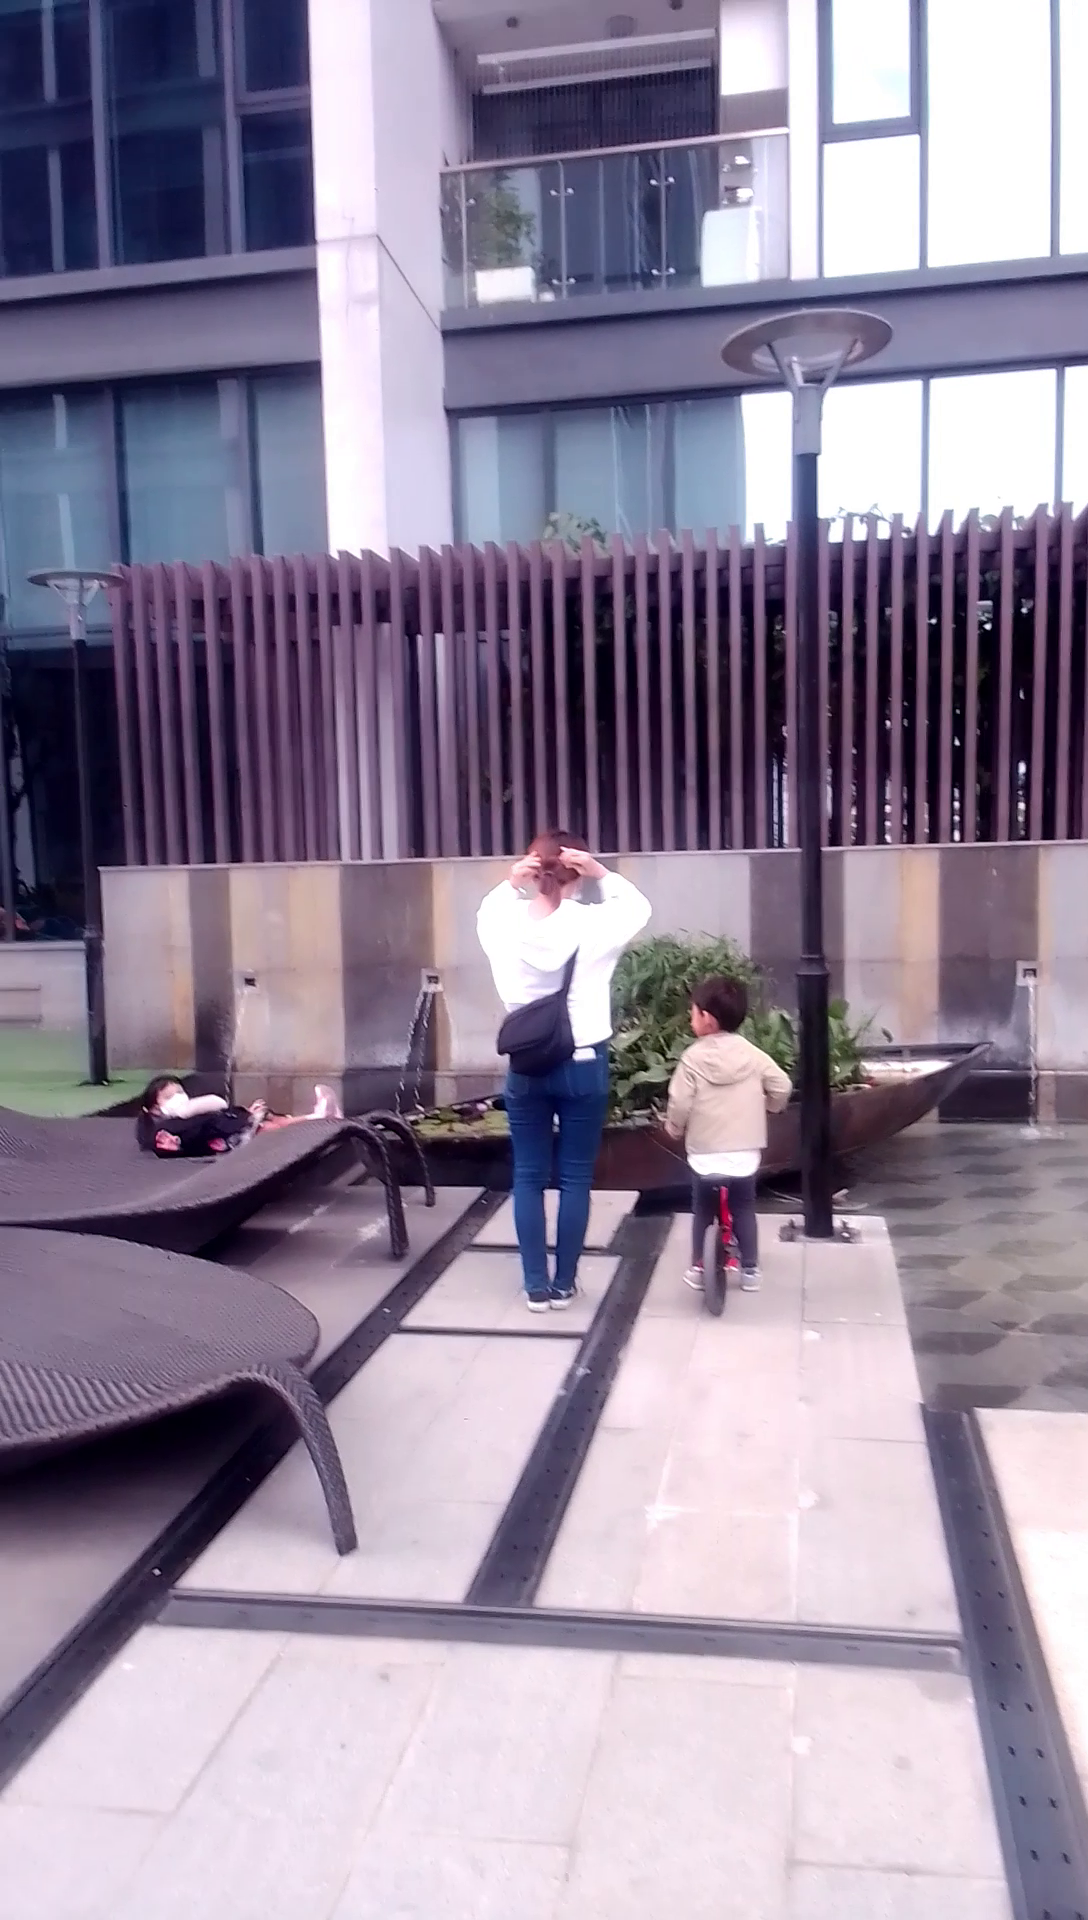

In [189]:
### Load Sample Video
vid, counts, fps, sample = load_video(video_file, -90, frame_pos)
print("There are",counts,"frames")
sample

In [190]:
cd {output_dir}

/Users/troydo42/Desktop/Body_Matrixes/outputs/2022_12_23


(157.20368952413298, 105.03061003906214, 147.96427671924883, 222.4761560048699)


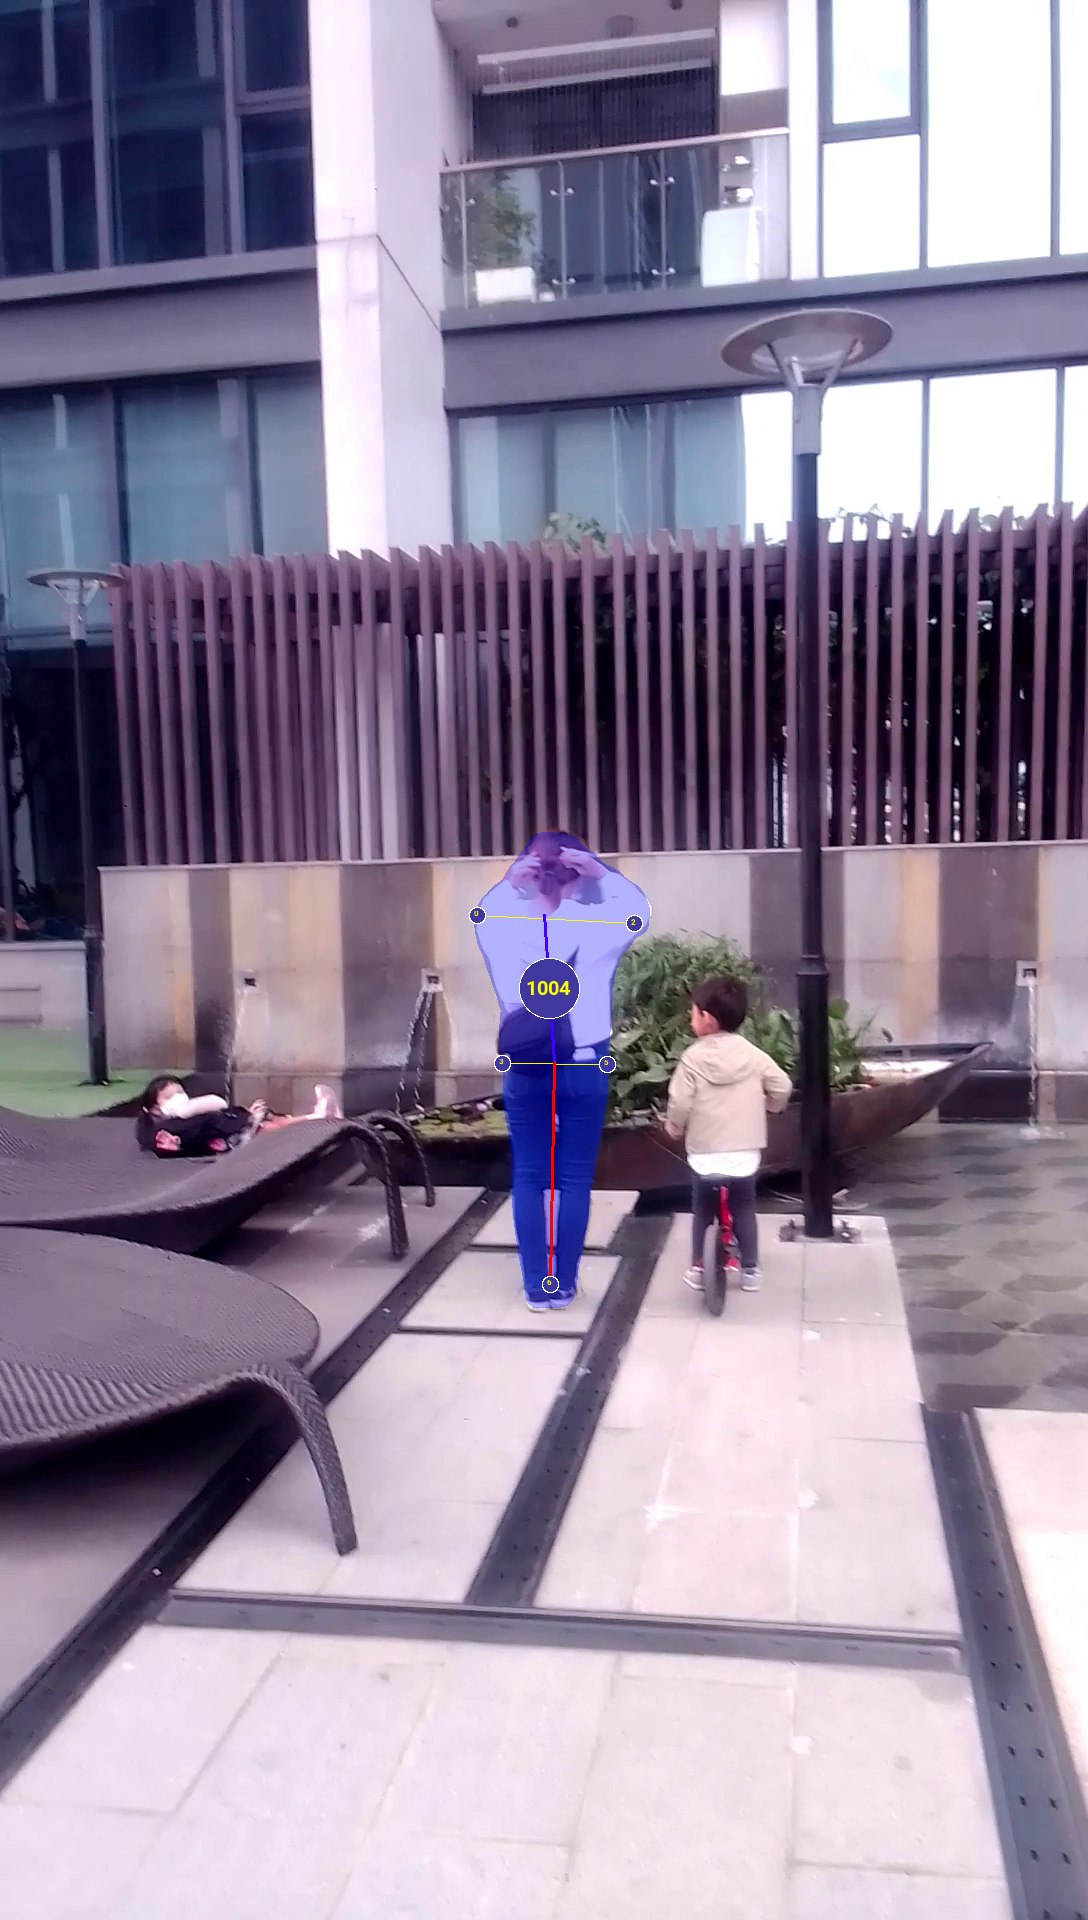

In [193]:
SHAImage, score, measures = process_frame(sample, sample_name)
print(measures)
SHAImage

## Processing Videos

In [ ]:
### Iterate over Every frames
scores = []
measures_store = []
for index, frame in enumerate(vid):
    image = to_pil_image(frame)
    image = image.rotate(90, expand=True)
    image_name = str(index)+"_"+video_file[-10:-4]
    SHAImage, score, measure = process_frame(image, image_name)
    scores.append(score)
    measures_store.append(measures)

In [ ]:
scores

In [ ]:
### Find Most Accurate Scores
import numpy as np
import seaborn as sns

def best_scores(array, min_val, max_val):
    scores = []
    for x in array:
        if x > max_val or x <  min_val:
            pass
        else:
            scores.append(x)
            
    np_scores = np.array(scores)
    mean = np.mean(np_scores)
    median = np.median(np_scores)
    minim = np.min(np_scores)
    maxim = np.max(np_scores)
    histogram_scores = np.histogram(np_scores)
    print(mean, median)
    sns.distplot(np_scores, hist=True)
    
    return mean, median, minim, maxim
    

In [ ]:
mean, median, minim, maxium = best_scores(scores, 1000,1500)

In [ ]:
median

In [ ]:
np.save("scores", scores, allow_pickle=True, fix_imports=True)

In [ ]:
np.save("measures", measures, allow_pickle=True, fix_imports=True)